This file should look very similar to notebooks 1 and 2

Main idea: Train with NLTK to get good initial probabilities for EM, fine-tune on data with EM

In [1]:
import sys
import os

# Add the scripts folder to the Python path
sys.path.append(os.path.abspath("../scripts"))  # Adjust the path accordingly

In [2]:
! pip install -U nltk

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import pickle
from load_data import *
from preprocessing import *
from baum_welch import *
import nltk
import matplotlib.pyplot as plt

In [4]:
data_file = "../data/brown-universal.txt"
tags_file = "../data/tags-universal.txt"
model_file = "../results/hmm_tagger-SS.pkl"
NLTK_model = "../results/hmm_tagger-NLTK.pkl"

# Load Data From File

In [5]:
train, test = load_brown_data(data_file, split=0.8)
tags = load_tags(tags_file)

In [6]:
print("There are {} sentences in the training set.".format(len(train)))
print("There are {} sentences in the testing set.".format(len(test)))

There are 45872 sentences in the training set.
There are 11468 sentences in the testing set.


In [7]:
# partition to train unsupervised HMM (should be a superset of the previous)
unsup_train_sample = train[10000:20000]

In [18]:
words = []
unsup_train_sentences = []
for sentence in unsup_train_sample:
    train_sentence = []
    for token in sentence:
        word = token.get_word()
        if word == '``' or word == "''":
            word = '"'
        words.append(word)
        train_sentence.append(word)
    unsup_train_sentences.append(train_sentence)

KeyboardInterrupt: 

In [9]:
words_lookup = {word: i for i, word in enumerate(words)}
tags_lookup = {tag: i for i, tag in enumerate(tags)}

# Semi-Supervised Training

## 1 Train HMM with NLTK

In [10]:
with open(NLTK_model, 'rb') as pickle_file:
    hmm_tagger_NLTK = pickle.load(pickle_file)

### Extract Features of NLTK-trained model

In [11]:
# Extract model parameters
tags_nltk = hmm_tagger_NLTK._states  # Set of all possible tags
words_nltk = hmm_tagger_NLTK._symbols  # Set of all possible words

# convert probability distributions of HMM to dictionaries
transitions_nltk = np.zeros((len(tags), len(tags)))
for prev_state in hmm_tagger_NLTK._transitions:
    i = tags_lookup[prev_state]
    for next_state in tags_nltk:
        j = tags_lookup[next_state]
        transitions_nltk[i][j] = hmm_tagger_NLTK._transitions[prev_state].prob(next_state)


emissions_nltk = np.zeros((len(tags), len(words)))
for state in tags_nltk:
    i = tags_lookup[state]
    rand_emission_prob = hmm_tagger_NLTK._outputs[state].prob(hmm_tagger_NLTK._outputs[state].generate())
    for word in words:
        k = words_lookup[word]
        if word in words_nltk:
            emissions_nltk[i][k] = hmm_tagger_NLTK._outputs[state].prob(word)
        else: 
            emissions_nltk[i][k] = rand_emission_prob # unseen word just as likely as some random emission

# normalize emission probabilities
row_sums = emissions_nltk.sum(axis=1)
emissions = emissions_nltk / row_sums[:, np.newaxis]

initial_nltk = np.zeros(len(tags))
for state in tags_nltk:
    i = tags_lookup[state]
    initial_nltk[i] = hmm_tagger_NLTK._priors.prob(state)

Verify that the initial probabilities are sound

In [12]:
trans_row_sums = transitions_nltk.sum(axis=1)
emissions_row_sums = emissions_nltk.sum(axis=1)
initials_sum = sum(initial_nltk)
print(trans_row_sums)
print(emissions_row_sums)
print(initials_sum)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.67542749e+03 1.48018241e+00 1.24979511e+03 1.89290121e+00
 2.52914076e+02 2.46714077e+03 2.50920860e+00 7.99936513e+00
 1.31813461e+00 3.11660170e+00 1.14231678e+00 1.44135919e+00]
1.0


## 2 Train HMM with Baum-welch

In [13]:
bw_tagger_500 = BaumWelch(tags, words)

In [14]:
bw_tagger_500.initialize_probabilities(transitions_nltk, emissions_nltk, initial_nltk, log=False)

/home/ezgibas/cs4100/ladino-pos/scripts/baum_welch.py:43: RuntimeWarning: divide by zero encountered in log2
  self.emission_probs = np.log2(emission)


In [15]:
num_samples = len(unsup_train_sentences)
batch_size = 50
batch_start = 0
batch_end = batch_size
done = False
batch_logprobs = []
while not done:
    (bw_tagger_500, logprobs) = bw_tagger_500.train_em(unsup_train_sentences[batch_start:batch_end], max_iterations=100)
    batch_logprobs.append(logprobs)
    batch_start = batch_end
    if batch_start >= num_samples:
        done = True
    else:
        batch_end = min(batch_start + batch_size, num_samples)
    if batch_end == num_samples:
        done = True

iteration 0 logprob -170.0624126488647
iteration 1 logprob -158.51075082489405
iteration 2 logprob -158.83050884609543
iteration 3 logprob -156.40808597485224
iteration 4 logprob -152.60529736881045
iteration 5 logprob -148.7968737441703
iteration 6 logprob -146.7066741871706
iteration 7 logprob -144.99077862422385
iteration 8 logprob -143.02296562942755
iteration 9 logprob -142.02222653168468
iteration 10 logprob -140.47557111517844
iteration 11 logprob -139.11300506754066
iteration 12 logprob -138.32794785796196
iteration 13 logprob -137.6155753549074
iteration 14 logprob -137.2623489542936
iteration 15 logprob -136.7926703918683
iteration 16 logprob -136.19737798734914
iteration 17 logprob -135.68502827646583
iteration 18 logprob -135.38333447666997
iteration 19 logprob -135.1110661449638
iteration 20 logprob -134.86450725145437
iteration 21 logprob -134.59518853209332
iteration 22 logprob -134.2703607389337
iteration 23 logprob -134.11130934484225
iteration 24 logprob -133.99590624

KeyboardInterrupt: 

In [16]:
bw_tagger_500.save_hmm(filename="../results/hmm_tagger-BW-50.pkl")

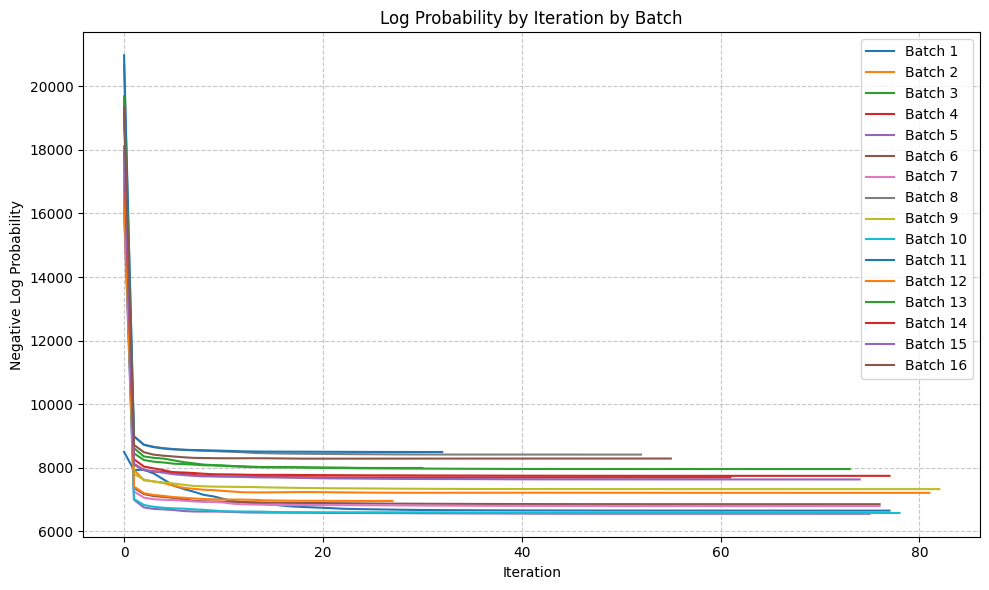

In [17]:
plt.figure(figsize=(10, 6))
for i, arr in enumerate(batch_logprobs):
    inverted_values = [-1 * val for val in arr]
    plt.plot(inverted_values, label=f'Batch {i+1}')

# add labels and title
plt.xlabel('Iteration')
plt.ylabel('Negative Log Probability')
plt.title('Log Probability by Iteration by Batch')

# add legend to distinguish between lines
plt.legend()

# add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# show the plot
plt.tight_layout()
plt.show()